In this notebook we show how to use the Pytorch SDO dataset and the data loader to pass the SDO dataset in batches to a NN model. **Last updated 17th July 2019.**

In [1]:
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from matplotlib.pyplot import imshow

import torch
from torch import nn, optim
from sdo.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

from sdo.models.encoder_decoder import AutoEncoder

%matplotlib inline

In [2]:
#just a way to get nice logging messages from the sdo package
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

In [33]:
subsample = 1
original_ratio = 512
img_shape = int(original_ratio/subsample)
instr = ['AIA', 'AIA', 'AIA']
channels = ['0171', '0193', '0094']
#instr = ['AIA']
#channels = ['0171']

In [34]:
#some cuda initialization
torch.backends.cudnn.enabled = True
cuda_device = 1
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available! Unable to continue")
device = torch.device("cuda:{}".format(cuda_device))
print("Using device {} for training, current device: {}, total devices: {}".format(
device, torch.cuda.current_device(), torch.cuda.device_count()))

Using device cuda:1 for training, current device: 0, total devices: 6


In [35]:
# after some discussion we found bytescaling seems more appropriate than the normalization beetween 0 and 1
# because in this way 
train_data = SDO_Dataset(device=device, instr=instr, channels=channels,
                   yr_range=[2015, 2018], subsample=subsample, normalization=0, bytescaling=True)
test_data = SDO_Dataset(device=device, instr=instr, channels=channels,
                   yr_range=[2015, 2018], subsample=subsample, normalization=0, bytescaling=True, test=True)

[2019-07-18 14:53:01] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-18 14:53:01] INFO:sdo.sdo_dataset:Running on months "[1 2 3 4 5 6 7 8]"
[2019-07-18 14:53:17] INFO:sdo.sdo_dataset:Number of SDO files = 2830
[2019-07-18 14:53:17] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-18 14:53:17] INFO:sdo.sdo_dataset:Running on months "[10 11 12]"
[2019-07-18 14:53:19] INFO:sdo.sdo_dataset:Number of SDO files = 359


In [24]:
train_data_loader = DataLoader(train_data, batch_size=10, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=10, shuffle=False)

0 torch.Size([10, 3, 512, 512])
tensor(45., device='cuda:1') tensor(0., device='cuda:1')
tensor([[1., 1., 1.,  ..., 1., 2., 1.],
        [1., 1., 2.,  ..., 1., 2., 1.],
        [2., 2., 1.,  ..., 1., 1., 2.],
        ...,
        [2., 1., 1.,  ..., 0., 1., 2.],
        [2., 1., 1.,  ..., 2., 1., 1.],
        [1., 2., 1.,  ..., 1., 2., 1.]], device='cuda:1')
45.0 0.0 2.3173087


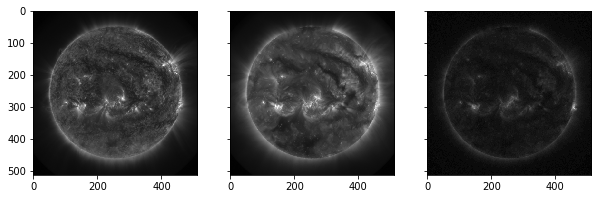

In [25]:
#a way to check the shape is as expected and the loader works
for batch_index, batch in enumerate(train_data_loader):
    print(batch_index, batch.shape)
    item = batch[4,2,:,:]
    print(torch.max(item), torch.min(item))
    print(item)
    print(item.cpu().numpy().max(), item.cpu().numpy().min(), item.cpu().numpy().std())
    fig, ax = plt.subplots(1, 3, figsize=(10,10), sharey=True)
    ax[0].imshow(batch[4,0,:,:].cpu().numpy(), cmap='gray')
    ax[1].imshow(batch[4,1,:,:].cpu().numpy(), cmap='gray')
    ax[2].imshow(batch[4,2,:,:].cpu().numpy(), cmap='gray')
    break

Since it seems to work we can try to run it on a simple model.

In [26]:
# initializaion of DNN model and parameters
model = AutoEncoder(input_shape=[len(channels), img_shape,img_shape])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

Autoencoder architecture:
Input shape: [3, 512, 512]
Input dim  : 786432
Encoded dim: 57600
Hidden dim : 512
Learnable params: 59669699


In [27]:
# training loop
model.cuda(cuda_device)
len_data = train_data.__len__()
log_interval = 10
n_epochs = 4
train_loss = []
for epoch in range(n_epochs):
    for batch_index, batch in enumerate(train_data_loader):
        data = batch.to(cuda_device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        train_loss.append(float(loss))
        loss.backward()
        optimizer.step()
        if batch_index % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_index * len(data), len_data, 
                100.*(batch_index* len(data)) / len_data, 
                loss.item() / len(data)))

Train Epoch: 0 [0/2829 (0%)]	Loss: 212.613037
Train Epoch: 0 [100/2829 (4%)]	Loss: 208.470605
Train Epoch: 0 [200/2829 (7%)]	Loss: 211.570190
Train Epoch: 0 [300/2829 (11%)]	Loss: 210.505640
Train Epoch: 0 [400/2829 (14%)]	Loss: 204.193555
Train Epoch: 0 [500/2829 (18%)]	Loss: 186.169312
Train Epoch: 0 [600/2829 (21%)]	Loss: 199.131299
Train Epoch: 0 [700/2829 (25%)]	Loss: 218.309326
Train Epoch: 0 [800/2829 (28%)]	Loss: 209.740869
Train Epoch: 0 [900/2829 (32%)]	Loss: 212.715845
Train Epoch: 0 [1000/2829 (35%)]	Loss: 173.443140
Train Epoch: 0 [1100/2829 (39%)]	Loss: 180.964172
Train Epoch: 0 [1200/2829 (42%)]	Loss: 197.193408
Train Epoch: 0 [1300/2829 (46%)]	Loss: 214.897266
Train Epoch: 0 [1400/2829 (49%)]	Loss: 200.215381
Train Epoch: 0 [1500/2829 (53%)]	Loss: 220.687915
Train Epoch: 0 [1600/2829 (57%)]	Loss: 221.361548
Train Epoch: 0 [1700/2829 (60%)]	Loss: 207.754956
Train Epoch: 0 [1800/2829 (64%)]	Loss: 182.234778
Train Epoch: 0 [1900/2829 (67%)]	Loss: 192.253931
Train Epoch: 0 

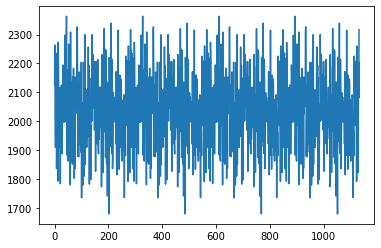

Loss min: 1678.4581298828125, max: 2363.524169921875, mean: 2029.0496261111418


In [32]:
# It does not converge, this will be explored in another notebook
plt.plot(train_loss, label='training loss');
plt.show();
print('Loss min: {}, max: {}, mean: {}'.format(min(train_loss), max(train_loss), np.mean(train_loss)))

In [29]:
#test loop
len_data = test_data.__len__()
log_interval = 10
n_epochs = 4
test_loss = []

for batch_index, batch in enumerate(test_data_loader):
    data = batch.to(cuda_device)
    recon_batch = model(data)
    loss = loss_function(recon_batch, data)
    test_loss.append(float(loss))
    if batch_index % log_interval == 0:
        print('Progress: {} , Test Loss: {:.6f}'.format(
            100.*(batch_index* len(data)) / len_data, loss.item() / len(data)))

Progress: 0.0 , Test Loss: 203.119604
Progress: 27.855153203342617 , Test Loss: 176.256909
Progress: 55.710306406685234 , Test Loss: 187.361475
Progress: 83.56545961002786 , Test Loss: 204.774402


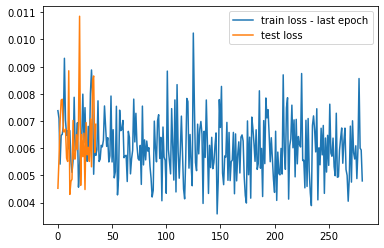

Loss min: 0.004301657434552908, max: 0.010855221189558506, mean: 0.006370824800493817


In [38]:
plt.plot(train_loss[-int(train_data.__len__()/10):], label='train loss - last epoch');
plt.plot(test_loss, label='test loss');
plt.legend()
plt.show();
print('Loss min: {}, max: {}, mean: {}'.format(min(test_loss), max(test_loss), np.mean(test_loss)))